In [5]:
# import required packages
from fastai.tabular import *

In [6]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [7]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [8]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba
77805,Grant_Hanley,18,2,90,Norwich,Wolverhampton Wanderers,0.295212,0.746215,True,0,1920,0.50
77806,Roberto_Pereyra,18,3,13,Watford,Manchester United,0.433797,1.560524,True,1,1920,0.75
77807,Sead_Kolasinac,18,2,0,Arsenal,Everton,1.413491,1.033814,False,0,1920,0.75
77808,Stuart_Armstrong,18,3,75,Southampton,Aston Villa,0.469252,0.522434,False,2,1920,1.00
77809,Rúben Diogo_da Silva Neves,18,3,90,Wolverhampton Wanderers,Norwich,0.746215,0.295212,False,2,1920,1.00


In [9]:
train_df.shape

(77810, 12)

In [10]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [11]:
train_df.shape

(77810, 12)

In [12]:
# find the latest gameweek
last_gw = train_df['gw'][train_df['season'] == '1920'].max()

if np.isnan(last_gw): 
    next_gw = 1 
else: 
    next_gw = last_gw + 1
    
next_gw

19

In [13]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == next_gw)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()
#valid_end = train_df.index.max()

In [14]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
season                                  object
play_proba                             float64
dtype: object

In [15]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']

In [16]:
# set dependent variable
dep_var = 'total_points'

In [17]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [18]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [19]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [20]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [ ]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [18]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1202, 85)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(30, 11)
    (4): Embedding(30, 11)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=133, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


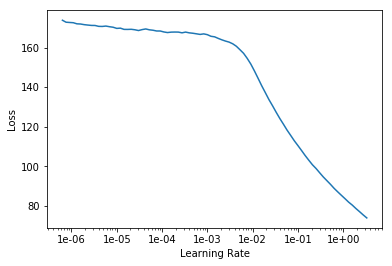

In [23]:
learn.recorder.plot()

In [ ]:
# no market value, latest half season validation
learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

In [43]:
# market value, latest half season validation
learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,10.148968,8.108212,2.815272,00:02
1,7.744442,7.921211,2.780680,00:02
2,6.750823,7.586754,2.719187,00:02


In [22]:
# no market value, new season validation
learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.286838,8.456475,2.861300,00:02
1,7.342739,7.591846,2.721933,00:02
2,7.386149,7.513053,2.702131,00:02
3,6.645412,7.562900,2.718028,00:02


In [ ]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time


In [ ]:
# second training run with lower LR
learn.fit_one_cycle(1, 1e-3, wd=0.2)

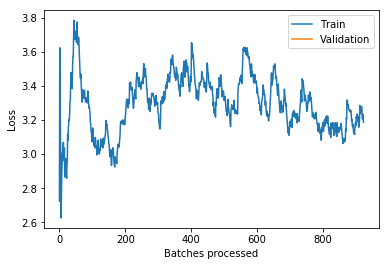

In [28]:
learn.recorder.plot_losses()

In [ ]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [ ]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

In [ ]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

In [ ]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

In [ ]:
prev_pt_mean = np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])
prev_pt_mean

In [25]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [26]:
remaining_season_df.head(50)
#remaining_season_df[remaining_season_df.player == 'Trent_Alexander-Arnold']

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,18,Aston Villa,Southampton,Ahmed_El Mohamady,2,4.2,1.00,True,0.522434,0.469252,1920,36.000000
1,18,Aston Villa,Southampton,James_Chester,2,4.3,1.00,True,0.522434,0.469252,1920,0.000000
2,18,Aston Villa,Southampton,Neil_Taylor,2,4.4,1.00,True,0.522434,0.469252,1920,0.000000
3,18,Aston Villa,Southampton,Kortney_Hause,2,4.4,1.00,True,0.522434,0.469252,1920,18.000000
4,18,Aston Villa,Southampton,Jonathan_Kodjia,4,5.4,1.00,True,0.522434,0.469252,1920,4.200000
5,18,Aston Villa,Southampton,Ørjan_Nyland,1,4.3,1.00,True,0.522434,0.469252,1920,0.000000
6,18,Aston Villa,Southampton,Conor_Hourihane,3,5.7,1.00,True,0.522434,0.469252,1920,45.400000
7,18,Aston Villa,Southampton,Jack_Grealish,3,6.2,1.00,True,0.522434,0.469252,1920,90.000000
8,18,Aston Villa,Southampton,Anwar_El Ghazi,3,5.5,1.00,True,0.522434,0.469252,1920,62.000000
9,18,Aston Villa,Southampton,John_McGinn,3,5.7,1.00,True,0.522434,0.469252,1920,90.000000


In [27]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [39]:
# instatiate new tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [40]:
# train as before
learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [41]:
learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [42]:
# get predictions
test_preds=learn.get_preds(DatasetType.Test)
remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [51]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
pred_pt_mean

5.033751487731934

In [28]:
while True:
    # instatiate new tabular learner
    learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                            y_range=y_range, metrics=rmse)
    
    # train as before
    learn.fit_one_cycle(2, 1e-2, wd=0.2)
    learn.fit_one_cycle(1, 1e-3, wd=0.2)

    # get predictions
    test_preds=learn.get_preds(DatasetType.Test)
    remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]
    
    # check mean of top predictions to see if it's reasonably close to previous season's actuals
    # re-run if not - not ideal but at the moment the training often over-predicts top players
    pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
    
    if abs((prev_pt_mean - pred_pt_mean) / prev_pt_mean) < 0.05:
        print("Mean of top 1000 predictions: {:.4}".format(pred_pt_mean))
        break
    else:
        print("retraining...")

Mean of top 1000 predictions: 4.941


In [29]:
remaining_season_df.shape

(12096, 13)

In [30]:
# quick look
remaining_season_df.sort_values(by='predicted_points', ascending=False).head(20)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
5779,38,Arsenal,Watford,Pierre-Emerick_Aubameyang,4,10.8,1.0,True,1.413491,0.433797,1920,90.0,10.825635
4050,32,Arsenal,Norwich,Pierre-Emerick_Aubameyang,4,10.8,1.0,True,1.413491,0.295212,1920,90.0,9.483395
2608,27,Arsenal,Everton,Pierre-Emerick_Aubameyang,4,10.8,1.0,True,1.413491,1.033814,1920,90.0,9.287500
3994,31,Tottenham Hotspur,West Ham United,Heung-Min_Son,3,10.1,1.0,True,2.001099,0.699185,1920,89.4,8.732315
4570,33,Tottenham Hotspur,Everton,Heung-Min_Son,3,10.1,1.0,True,2.001099,1.033814,1920,89.4,8.720653
2324,26,Arsenal,Newcastle United,Pierre-Emerick_Aubameyang,4,10.8,1.0,True,1.413491,0.561705,1920,90.0,8.694424
3184,29,Arsenal,West Ham United,Pierre-Emerick_Aubameyang,4,10.8,1.0,True,1.413491,0.699185,1920,90.0,8.673399
534,19,Tottenham Hotspur,Brighton and Hove Albion,Heung-Min_Son,3,10.1,1.0,True,2.001099,0.453089,1920,89.4,8.642734
7725,23,Tottenham Hotspur,Watford,Heung-Min_Son,3,10.1,1.0,False,2.001099,0.433797,1920,89.4,8.516046
5947,38,Manchester City,Norwich,Raheem_Sterling,3,11.8,1.0,True,2.711234,0.295212,1920,86.2,8.437416


In [31]:
# rename previous week's predictions file
# generate previous week's filename
last_gw = next_gw - 1
filename = 'predictions_gw' + str(last_gw) + '.csv'
! mv predictions.csv $filename

In [32]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')